## Context

Reservation cancellation is not uncommon in the hotel industry. Each cancellation means a lost revenue opportunity that can never be recovered. When working at the front desk at an airport hotel, we had to call each guest to confirm if they will show up in the afternoon. If they confirm that they cannot show up, we could try to sell the room again. This practice ensures the revenue to a certain degree. However, it is not sufficient to call each guest in the afternoon since a majority of guests check-in during the afternoon. 

Therefore, if we can predict if a guest would cancel a reservation, hotels could contact guests that most likely to cancel to confirm more efficiently and to resell the room to optimize revenues.

## Content
This [data](https://www.kaggle.com/jessemostipak/hotel-booking-demand) set contains booking information for a city hotel and a resort hotel, and includes information such as when the booking was made, length of stay, the number of adults, children, and/or babies, and the number of available parking spaces, among other things.

## Questions
1. Which hotel has more cancelations?
2. Any difference in lead time?
3. How about ADR?
4. Would Deposit Type makes a difference?
5. Any difference in market segments?
6. How about distribution channels?
7. How about Month, Day, and Week Number?







### Import Dataset & Preparation

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
%matplotlib inline

In [2]:
# load the dataset
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datasets/hotel_bookings.csv')
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [3]:
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


In [4]:
# check for missing values
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

There are many missing values in agent & company columns. These two columns can be dropped. We can drop the missing value in country & children since there is only small proportion missing values.

In [5]:
# check for the shape of dataset
df.shape

(119390, 32)

In [6]:
# check for data type of each column
df.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [7]:
df['is_canceled'].value_counts(normalize=True)

0    0.629584
1    0.370416
Name: is_canceled, dtype: float64

In [8]:
df['reservation_status'].value_counts(normalize=True)

Check-Out    0.629584
Canceled     0.360307
No-Show      0.010110
Name: reservation_status, dtype: float64

is_canceled & reservation_status provide same information, we can drop reservation_status for model building purpose

In [9]:
df.drop(columns=['agent', 'company', 'reservation_status'],inplace=True)
df.dropna(axis=0,inplace=True)
df.shape

(118898, 29)

In [10]:
df.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests   

In [11]:
df['meal'].value_counts()

BB           91863
HB           14434
SC           10638
Undefined     1165
FB             798
Name: meal, dtype: int64

In [0]:
# "meal" contains values "Undefined", which is equal to SC
df['meal'].replace('Undefined','SC',inplace=True)

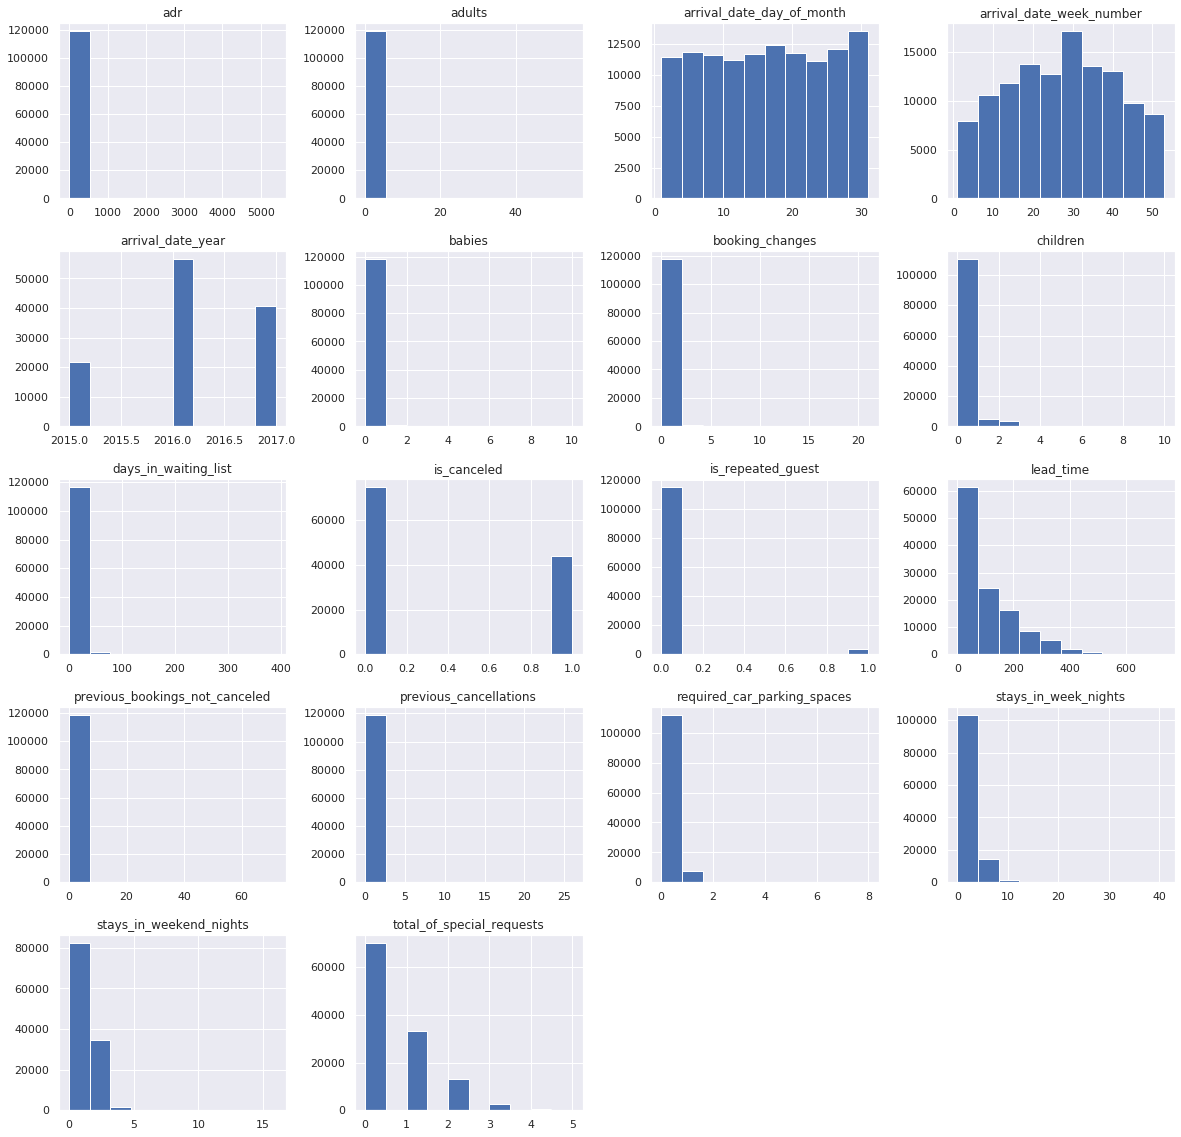

In [13]:
df.hist(figsize=(20,20))
plt.show()

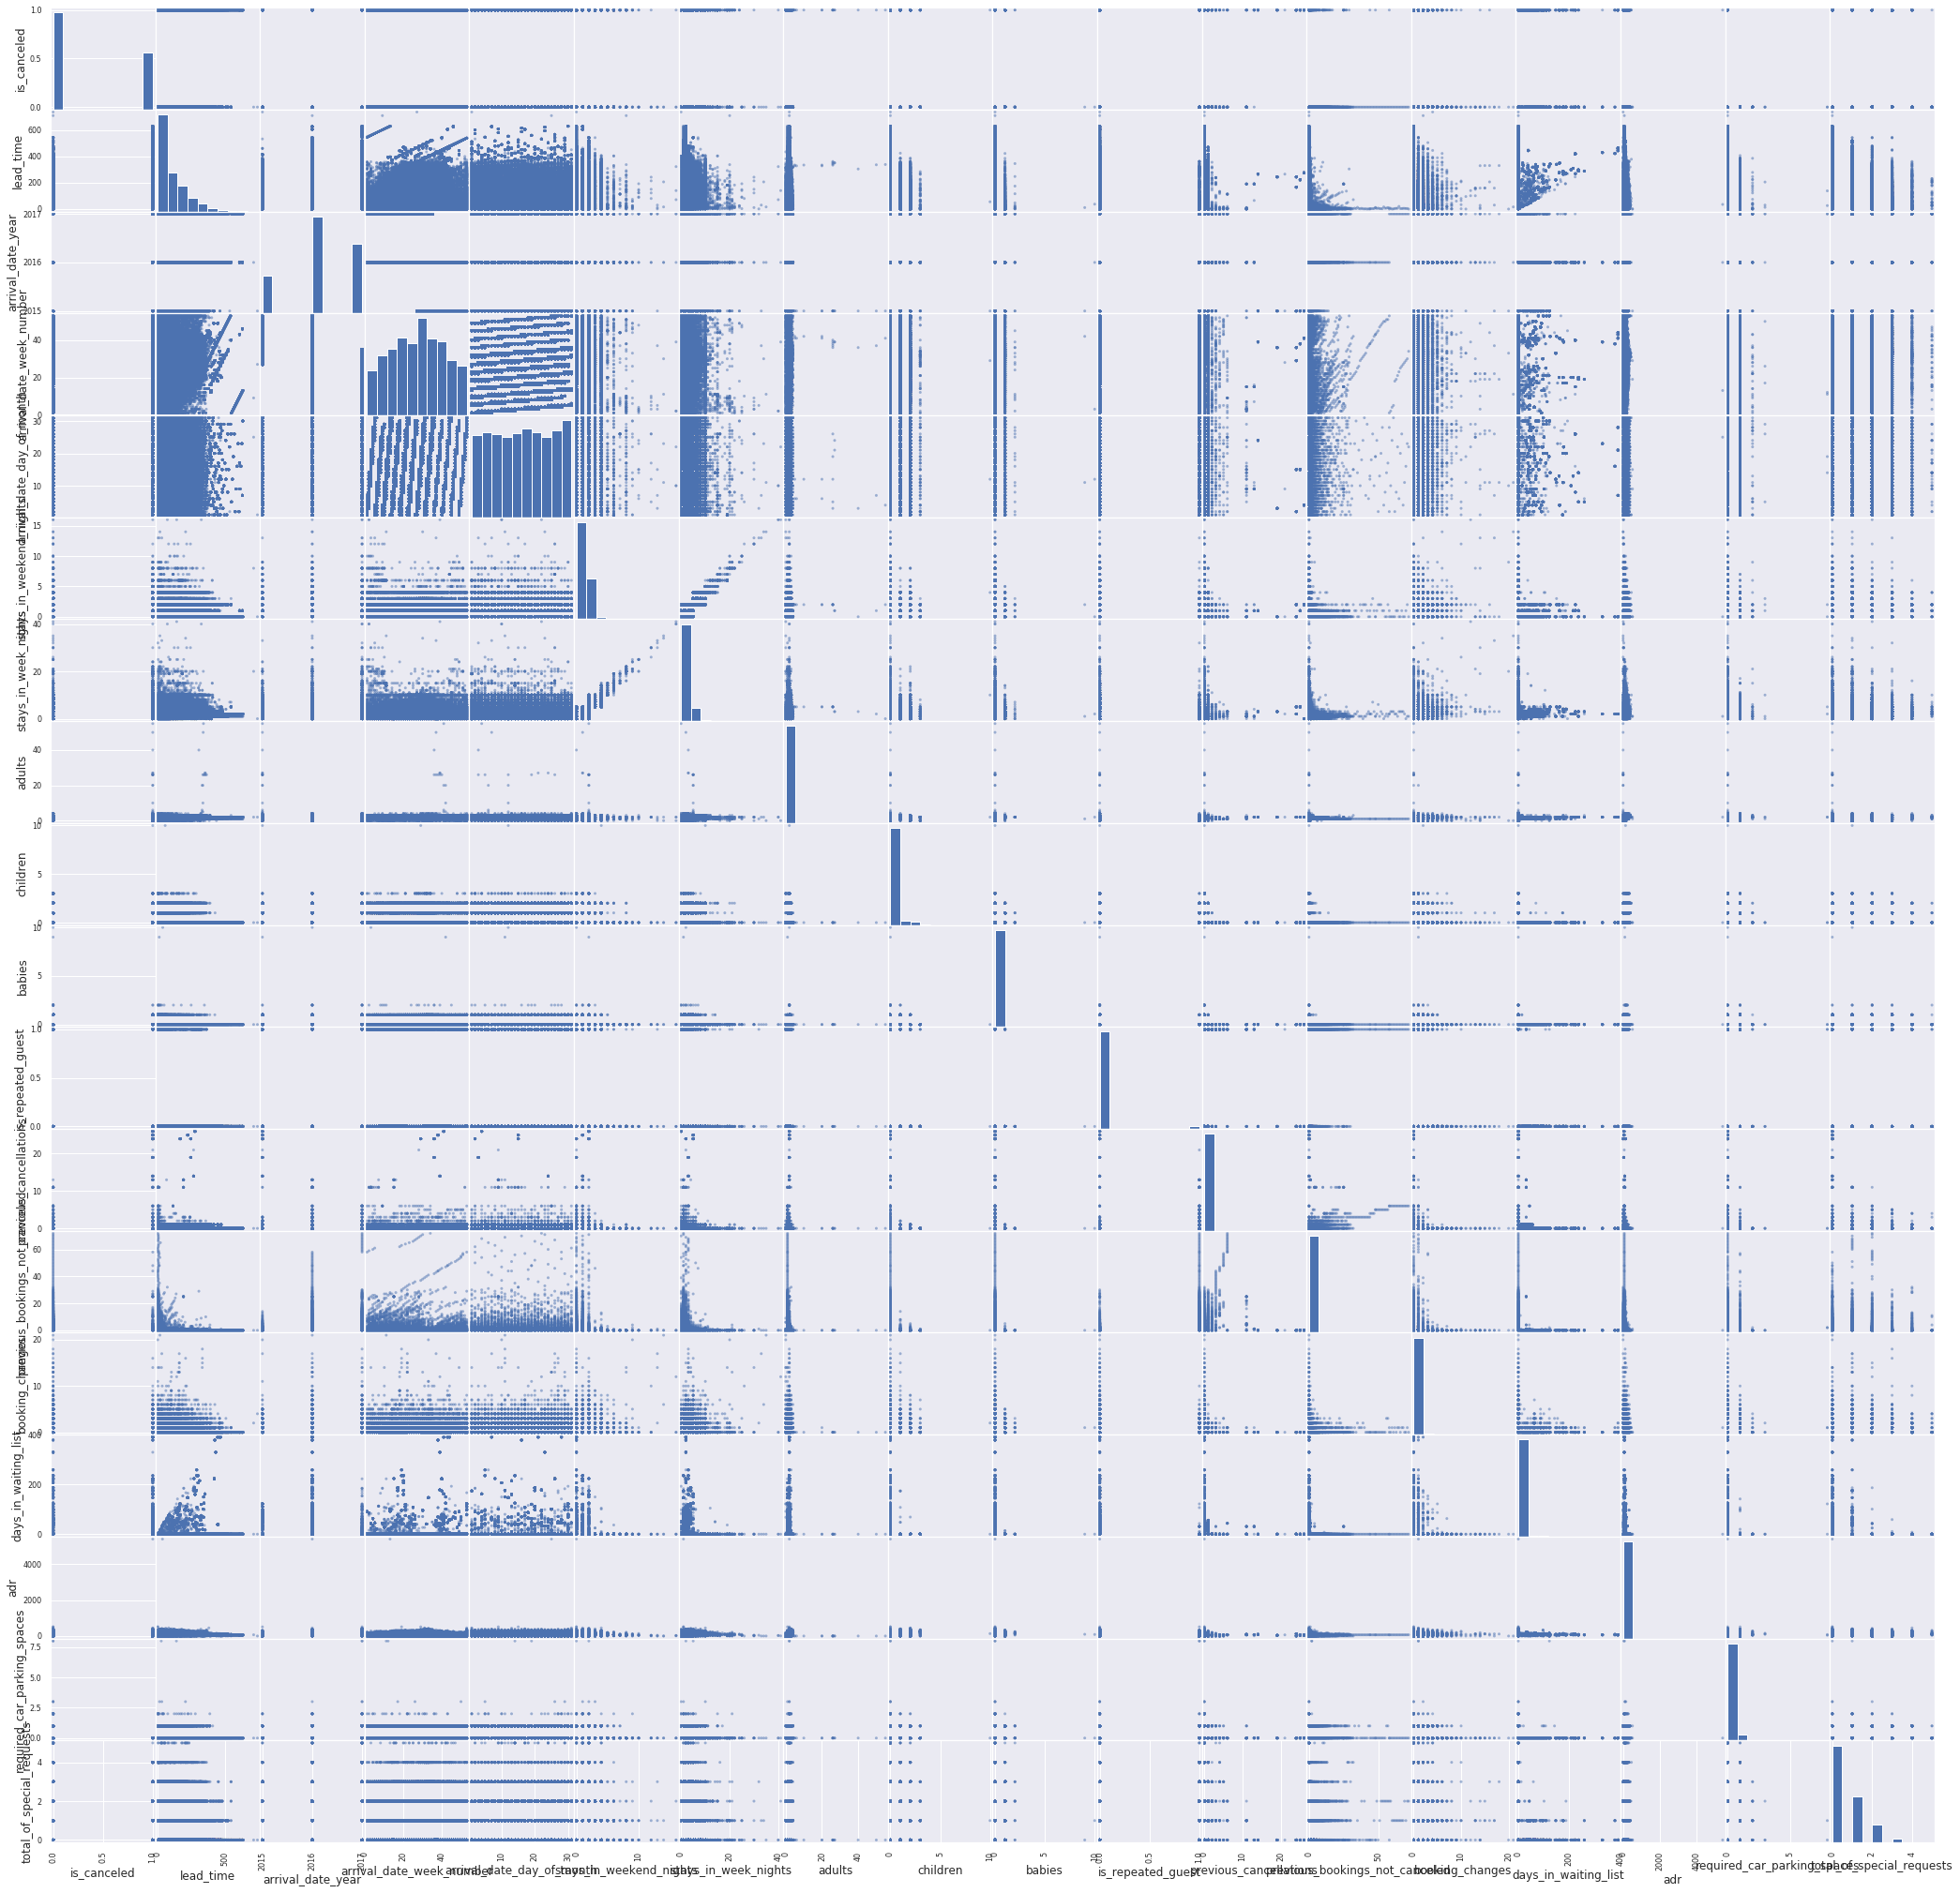

In [14]:
from pandas.plotting import scatter_matrix
scatter_matrix(df,figsize=(36,36))
plt.show()

Looks like there are some reservation with 0 adults, we need to take a look at those records.

In [15]:
len(df[(df['adults']==0) & (df['children']==0) & (df['babies']==0)])

170

There are 170 records with 0 adults, 0 children, and 0 babies. We can drop these rows

In [16]:
zero_guests = df[(df['adults']==0) & (df['children']==0) & (df['babies']==0)].index
df.drop(zero_guests, inplace=True)
df.shape

(118728, 29)

### EDA

Now the data is cleaned and ready for analysis.

#### Which hotel has more cancelations?

In [18]:
print('There are ' + str(len(df[(df['hotel']=='Resort Hotel') & (df['is_canceled']==1)])) + ' cancelations at Resort Hotel')
print('There are ' + str(len(df[(df['hotel']=='City Hotel') & (df['is_canceled']==1)])) + ' cancelations at City Hotel')

There are 11077 cancelations at Resort Hotel
There are 33061 cancelations at City Hotel


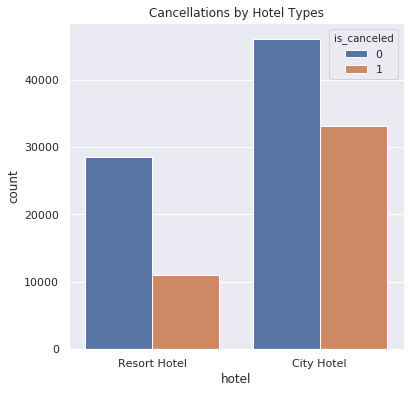

In [19]:
plt.figure(figsize=(6,6))
plt.title(label='Cancellations by Hotel Types')
sns.countplot(x='hotel',hue='is_canceled',data=df)
plt.show()

In [20]:
# % of cancellations in Resort Hotel
df[df['hotel']=='Resort Hotel']['is_canceled'].value_counts(normalize=True)

0    0.720172
1    0.279828
Name: is_canceled, dtype: float64

In [21]:
# % of cancellations in City Hotel
df[df['hotel']=='City Hotel']['is_canceled'].value_counts(normalize=True)

0    0.582262
1    0.417738
Name: is_canceled, dtype: float64

City Hotel has a higher cancellations rate
of 41.78% comparing to Resort Hotel’s
27.98%


#### Any difference in lead time?

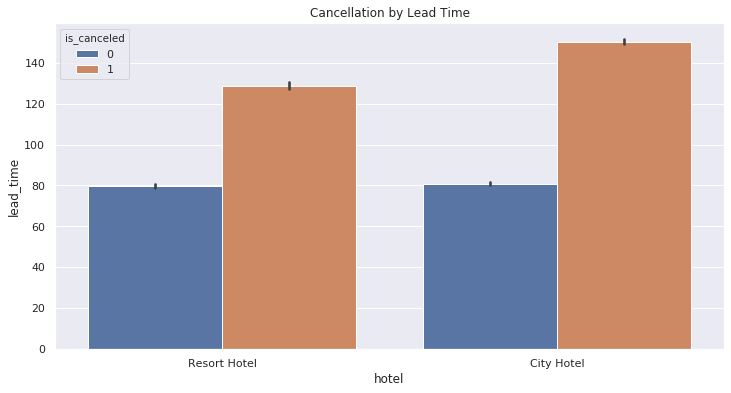

In [22]:
plt.figure(figsize=(12,6))
plt.title(label='Cancellation by Lead Time')
sns.barplot(x='hotel',y='lead_time',hue='is_canceled',data=df)
plt.show()

Looks like the longer the lead time, the reservation is more likely to be canceled.

#### How about ADR?

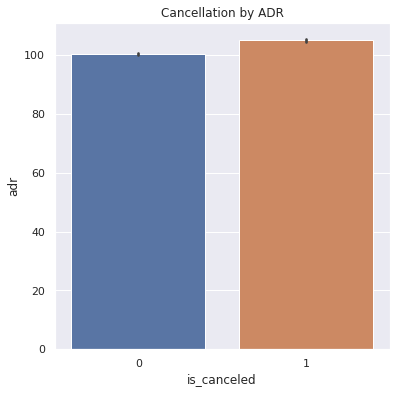

In [23]:
plt.figure(figsize=(6,6))
plt.title(label='Cancellation by ADR')
sns.barplot(x='is_canceled',y='adr',data=df)
plt.show()

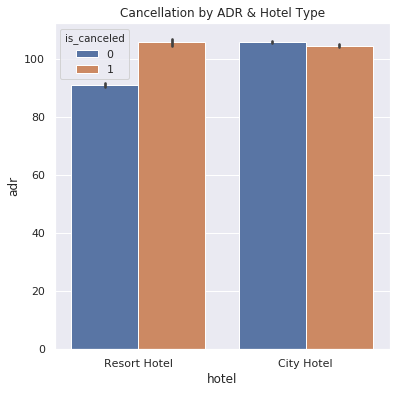

In [24]:
plt.figure(figsize=(6,6))
plt.title(label='Cancellation by ADR & Hotel Type')
sns.barplot(x='hotel',y='adr',hue='is_canceled',data=df)
plt.show()

Looks like the cancellations in Resort Hotels had a higher ADR.

#### Would Deposit Type makes a difference?

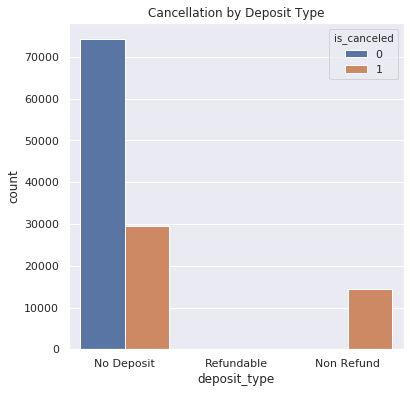

In [25]:
plt.figure(figsize=(6,6))
plt.title(label='Cancellation by Deposit Type')
sns.countplot(x='deposit_type',hue='is_canceled',data=df)
plt.show()

Reservations with No-deposit or
Non-refund policy are more likely
to be canceled

#### Any difference in market segments?

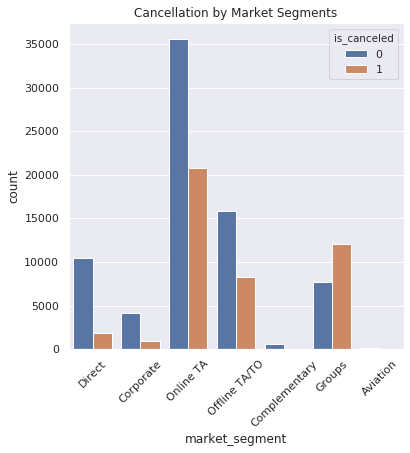

In [26]:
plt.figure(figsize=(6,6))
plt.title(label='Cancellation by Market Segments')
plt.xticks(rotation=45) 
sns.countplot(x='market_segment',hue='is_canceled',data=df)
plt.show()

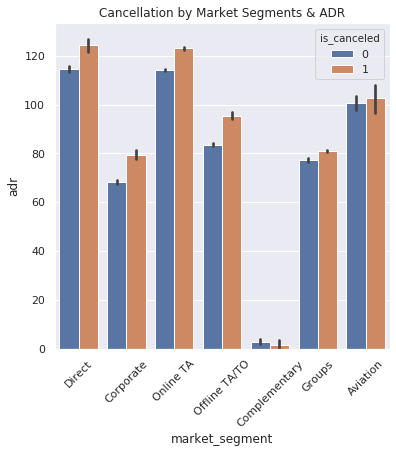

In [27]:
plt.figure(figsize=(6,6))
plt.title(label='Cancellation by Market Segments & ADR')
plt.xticks(rotation=45) 
sns.barplot(x='market_segment',y='adr',hue='is_canceled',data=df)
plt.show()

• The cancellation percentage
of groups is higher than
other segments

• The cancellation number of
Online TA is higher than
other segments

• Almost all canceled reservations have a higher ADR.

#### Distribution Channels

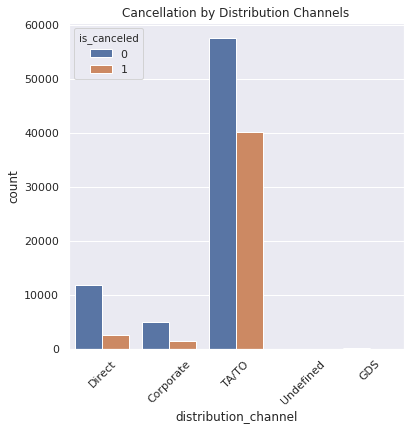

In [28]:
plt.figure(figsize=(6,6))
plt.title(label='Cancellation by Distribution Channels')
plt.xticks(rotation=45) 
sns.countplot(x='distribution_channel',hue='is_canceled',data=df)
plt.show()

Reservations from Travel Agents or
Tour Operators are more likely to
be canceled

#### Cancellations by Month, Day and Week Number

In [0]:
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'], format='%Y-%m-%d')

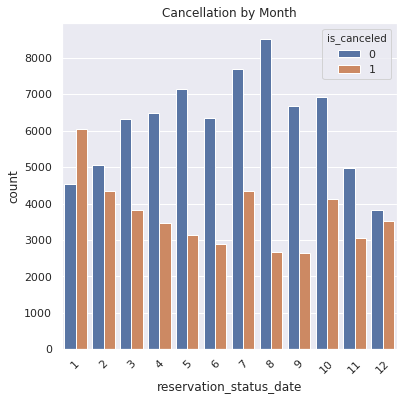

In [30]:
plt.figure(figsize=(6,6))
plt.title(label='Cancellation by Month')
plt.xticks(rotation=45) 
sns.countplot(x=df['reservation_status_date'].dt.month,hue='is_canceled',data=df)
plt.show()

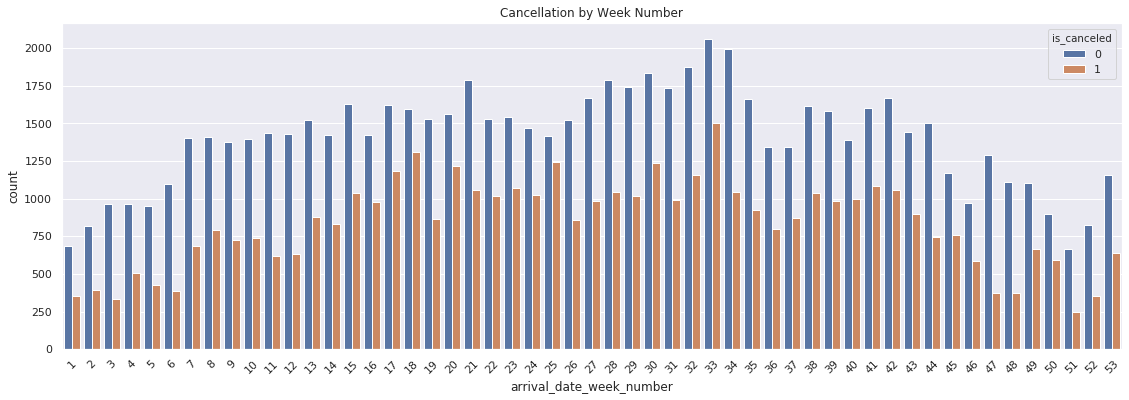

In [31]:
plt.figure(figsize=(19,6))
plt.title(label='Cancellation by Week Number')
plt.xticks(rotation=45) 
sns.countplot(x=df['arrival_date_week_number'],hue='is_canceled',data=df)
plt.show()

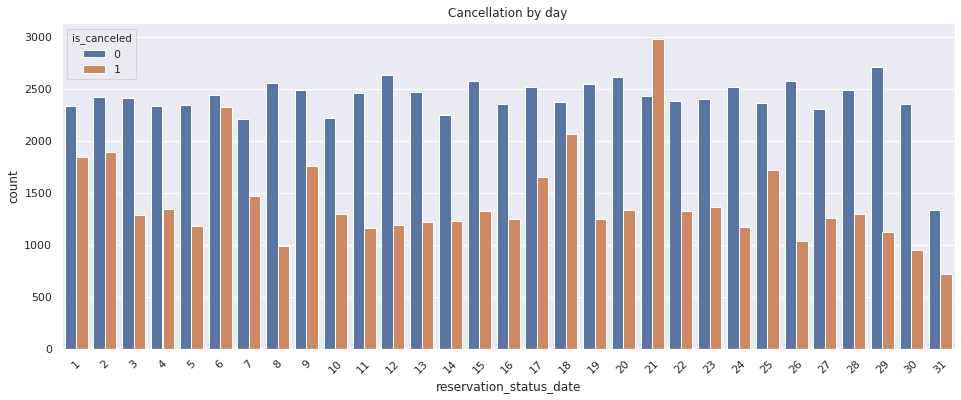

In [32]:
plt.figure(figsize=(16,6))
plt.title(label='Cancellation by day')
plt.xticks(rotation=45) 
sns.countplot(x=df['reservation_status_date'].dt.day,hue='is_canceled',data=df)
plt.show()

### Modeling

I will look up 1's precision, recall, accuracy as model metrics as well as interpretability to decide the best model.

In [0]:
cat_cols=['is_canceled','arrival_date_month','meal','market_segment','distribution_channel','reserved_room_type',
      'is_repeated_guest','deposit_type','customer_type']
df[cat_cols] = df[cat_cols].astype('category')

In [0]:
num_cols = ['lead_time','arrival_date_week_number','arrival_date_day_of_month','stays_in_weekend_nights','stays_in_week_nights',
        'adults','children','babies','previous_cancellations','previous_bookings_not_canceled','required_car_parking_spaces',
        'total_of_special_requests','adr']

In [35]:
model_df = df[cat_cols+num_cols]
model_df.shape

(118728, 22)

In [36]:
model_df.corr()

,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,previous_cancellations,previous_bookings_not_canceled,required_car_parking_spaces,total_of_special_requests,adr
lead_time,1.000000,0.126875,0.002402,0.084327,0.165913,0.115020,-0.038580,-0.021231,0.085949,-0.071164,-0.115707,-0.096710,-0.068174
arrival_date_week_number,0.126875,1.000000,0.066577,0.018086,0.015531,0.025956,0.005527,0.010058,0.035354,-0.020876,0.001770,0.025810,0.075699
arrival_date_day_of_month,0.002402,0.066577,1.000000,-0.015739,-0.027723,-0.001884,0.014570,-0.000541,-0.027024,0.000116,0.008158,0.003078,0.030053
stays_in_weekend_nights,0.084327,0.018086,-0.015739,1.000000,0.490100,0.093397,0.045780,0.018523,-0.012998,-0.040727,-0.018099,0.072146,0.048701
stays_in_week_nights,0.165913,0.015531,-0.027723,0.490100,1.000000,0.095399,0.044723,0.020343,-0.014252,-0.047478,-0.024431,0.067360,0.065344
adults,0.115020,0.025956,-0.001884,0.093397,0.095399,1.000000,0.028603,0.017642,-0.007278,-0.105795,0.016107,0.122418,0.221413
children,-0.038580,0.005527,0.014570,0.045780,0.044723,0.028603,1.000000,0.024101,-0.024775,-0.020368,0.057059,0.081811,0.325228
babies,-0.021231,0.010058,-0.000541,0.018523,0.020343,0.017642,0.024101,1.000000,-0.007496,-0.006306,0.036979,0.097654,0.028455
previous_cancellations,0.085949,0.035354,-0.027024,-0.012998,-0.014252,-0.007278,-0.024775,-0.007496,1.000000,0.154127,-0.018500,-0.048681,-0.066233
previous_bookings_not_canceled,-0.071164,-0.020876,0.000116,-0.040727,-0.047478,-0.105795,-0.020368,-0.006306,0.154127,1.000000,0.046798,0.037551,-0.069786


In [0]:
df_dummies = pd.get_dummies(model_df.drop(columns=['is_canceled']))

In [38]:
df_dummies.head()

,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,previous_cancellations,previous_bookings_not_canceled,required_car_parking_spaces,total_of_special_requests,adr,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,meal_BB,meal_FB,meal_HB,meal_SC,market_segment_Aviation,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,is_repeated_guest_0,is_repeated_guest_1,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,342,27,1,0,0,2,0.0,0,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0
1,737,27,1,0,0,2,0.0,0,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0
2,7,27,1,0,1,1,0.0,0,0,0,0,0,75.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0
3,13,27,1,0,1,1,0.0,0,0,0,0,0,75.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0
4,14,27,1,0,2,2,0.0,0,0,0,0,1,98.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0


In [0]:
y = model_df['is_canceled']
X = df_dummies

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)
sc = StandardScaler()

In [0]:
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

##### Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression

In [44]:
lr = LogisticRegression()
lr.fit(X_train_std, y_train)
y_lr_pred = lr.predict(X_test_std)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [45]:
print('Accuracy: %.4f' % accuracy_score(y_test, y_lr_pred))
print(confusion_matrix(y_test, y_lr_pred))
print(classification_report(y_test,y_lr_pred))

Accuracy: 0.8044
[[20893  1420]
 [ 5546  7760]]
              precision    recall  f1-score   support

           0       0.79      0.94      0.86     22313
           1       0.85      0.58      0.69     13306

    accuracy                           0.80     35619
   macro avg       0.82      0.76      0.77     35619
weighted avg       0.81      0.80      0.79     35619



##### Decision Tree

In [0]:
from sklearn.tree import DecisionTreeClassifier

In [0]:
clf = DecisionTreeClassifier()
clf.fit(X_train_std, y_train)
y_clf_pred = clf.predict(X_test_std)

In [48]:
print('Accuracy: %.4f' % accuracy_score(y_test, y_clf_pred))
print(confusion_matrix(y_test, y_clf_pred))
print(classification_report(y_test,y_clf_pred))

Accuracy: 0.8161
[[19023  3290]
 [ 3259 10047]]
              precision    recall  f1-score   support

           0       0.85      0.85      0.85     22313
           1       0.75      0.76      0.75     13306

    accuracy                           0.82     35619
   macro avg       0.80      0.80      0.80     35619
weighted avg       0.82      0.82      0.82     35619



##### Ada Boosting

In [0]:
from sklearn.ensemble import AdaBoostClassifier

In [0]:
ada = AdaBoostClassifier()
ada.fit(X_train_std, y_train)
y_ada_pred = ada.predict(X_test_std)

In [51]:
print('Accuracy: %.4f' % accuracy_score(y_test, y_ada_pred))
print(confusion_matrix(y_test, y_ada_pred))
print(classification_report(y_test,y_ada_pred))

Accuracy: 0.8124
[[20750  1563]
 [ 5119  8187]]
              precision    recall  f1-score   support

           0       0.80      0.93      0.86     22313
           1       0.84      0.62      0.71     13306

    accuracy                           0.81     35619
   macro avg       0.82      0.77      0.79     35619
weighted avg       0.82      0.81      0.80     35619



##### Gradient Boosting

In [0]:
from sklearn.ensemble import GradientBoostingClassifier

In [0]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train_std, y_train)
y_gbc_pred = gbc.predict(X_test_std)

In [54]:
print('Accuracy: %.4f' % accuracy_score(y_test, y_gbc_pred))
print(confusion_matrix(y_test, y_gbc_pred))
print(classification_report(y_test,y_gbc_pred))

Accuracy: 0.8137
[[20835  1478]
 [ 5159  8147]]
              precision    recall  f1-score   support

           0       0.80      0.93      0.86     22313
           1       0.85      0.61      0.71     13306

    accuracy                           0.81     35619
   macro avg       0.82      0.77      0.79     35619
weighted avg       0.82      0.81      0.81     35619



##### XGBoost

In [0]:
from xgboost import XGBClassifier

In [0]:
xgb = XGBClassifier()
xgb.fit(X_train_std, y_train)
y_xgb_pred = xgb.predict(X_test_std)

In [57]:
print('Accuracy: %.4f' % accuracy_score(y_test, y_xgb_pred))
print(confusion_matrix(y_test, y_xgb_pred))
print(classification_report(y_test,y_xgb_pred))

Accuracy: 0.8129
[[20843  1470]
 [ 5194  8112]]
              precision    recall  f1-score   support

           0       0.80      0.93      0.86     22313
           1       0.85      0.61      0.71     13306

    accuracy                           0.81     35619
   macro avg       0.82      0.77      0.79     35619
weighted avg       0.82      0.81      0.80     35619



##### Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
rfl = RandomForestClassifier()
rfl.fit(X_train_std, y_train)
y_rfl_pred = rfl.predict(X_test_std)

In [60]:
print('Accuracy: %.4f' % accuracy_score(y_test, y_rfl_pred))
print(confusion_matrix(y_test, y_rfl_pred))
print(classification_report(y_test,y_rfl_pred))

Accuracy: 0.8570
[[20662  1651]
 [ 3443  9863]]
              precision    recall  f1-score   support

           0       0.86      0.93      0.89     22313
           1       0.86      0.74      0.79     13306

    accuracy                           0.86     35619
   macro avg       0.86      0.83      0.84     35619
weighted avg       0.86      0.86      0.85     35619



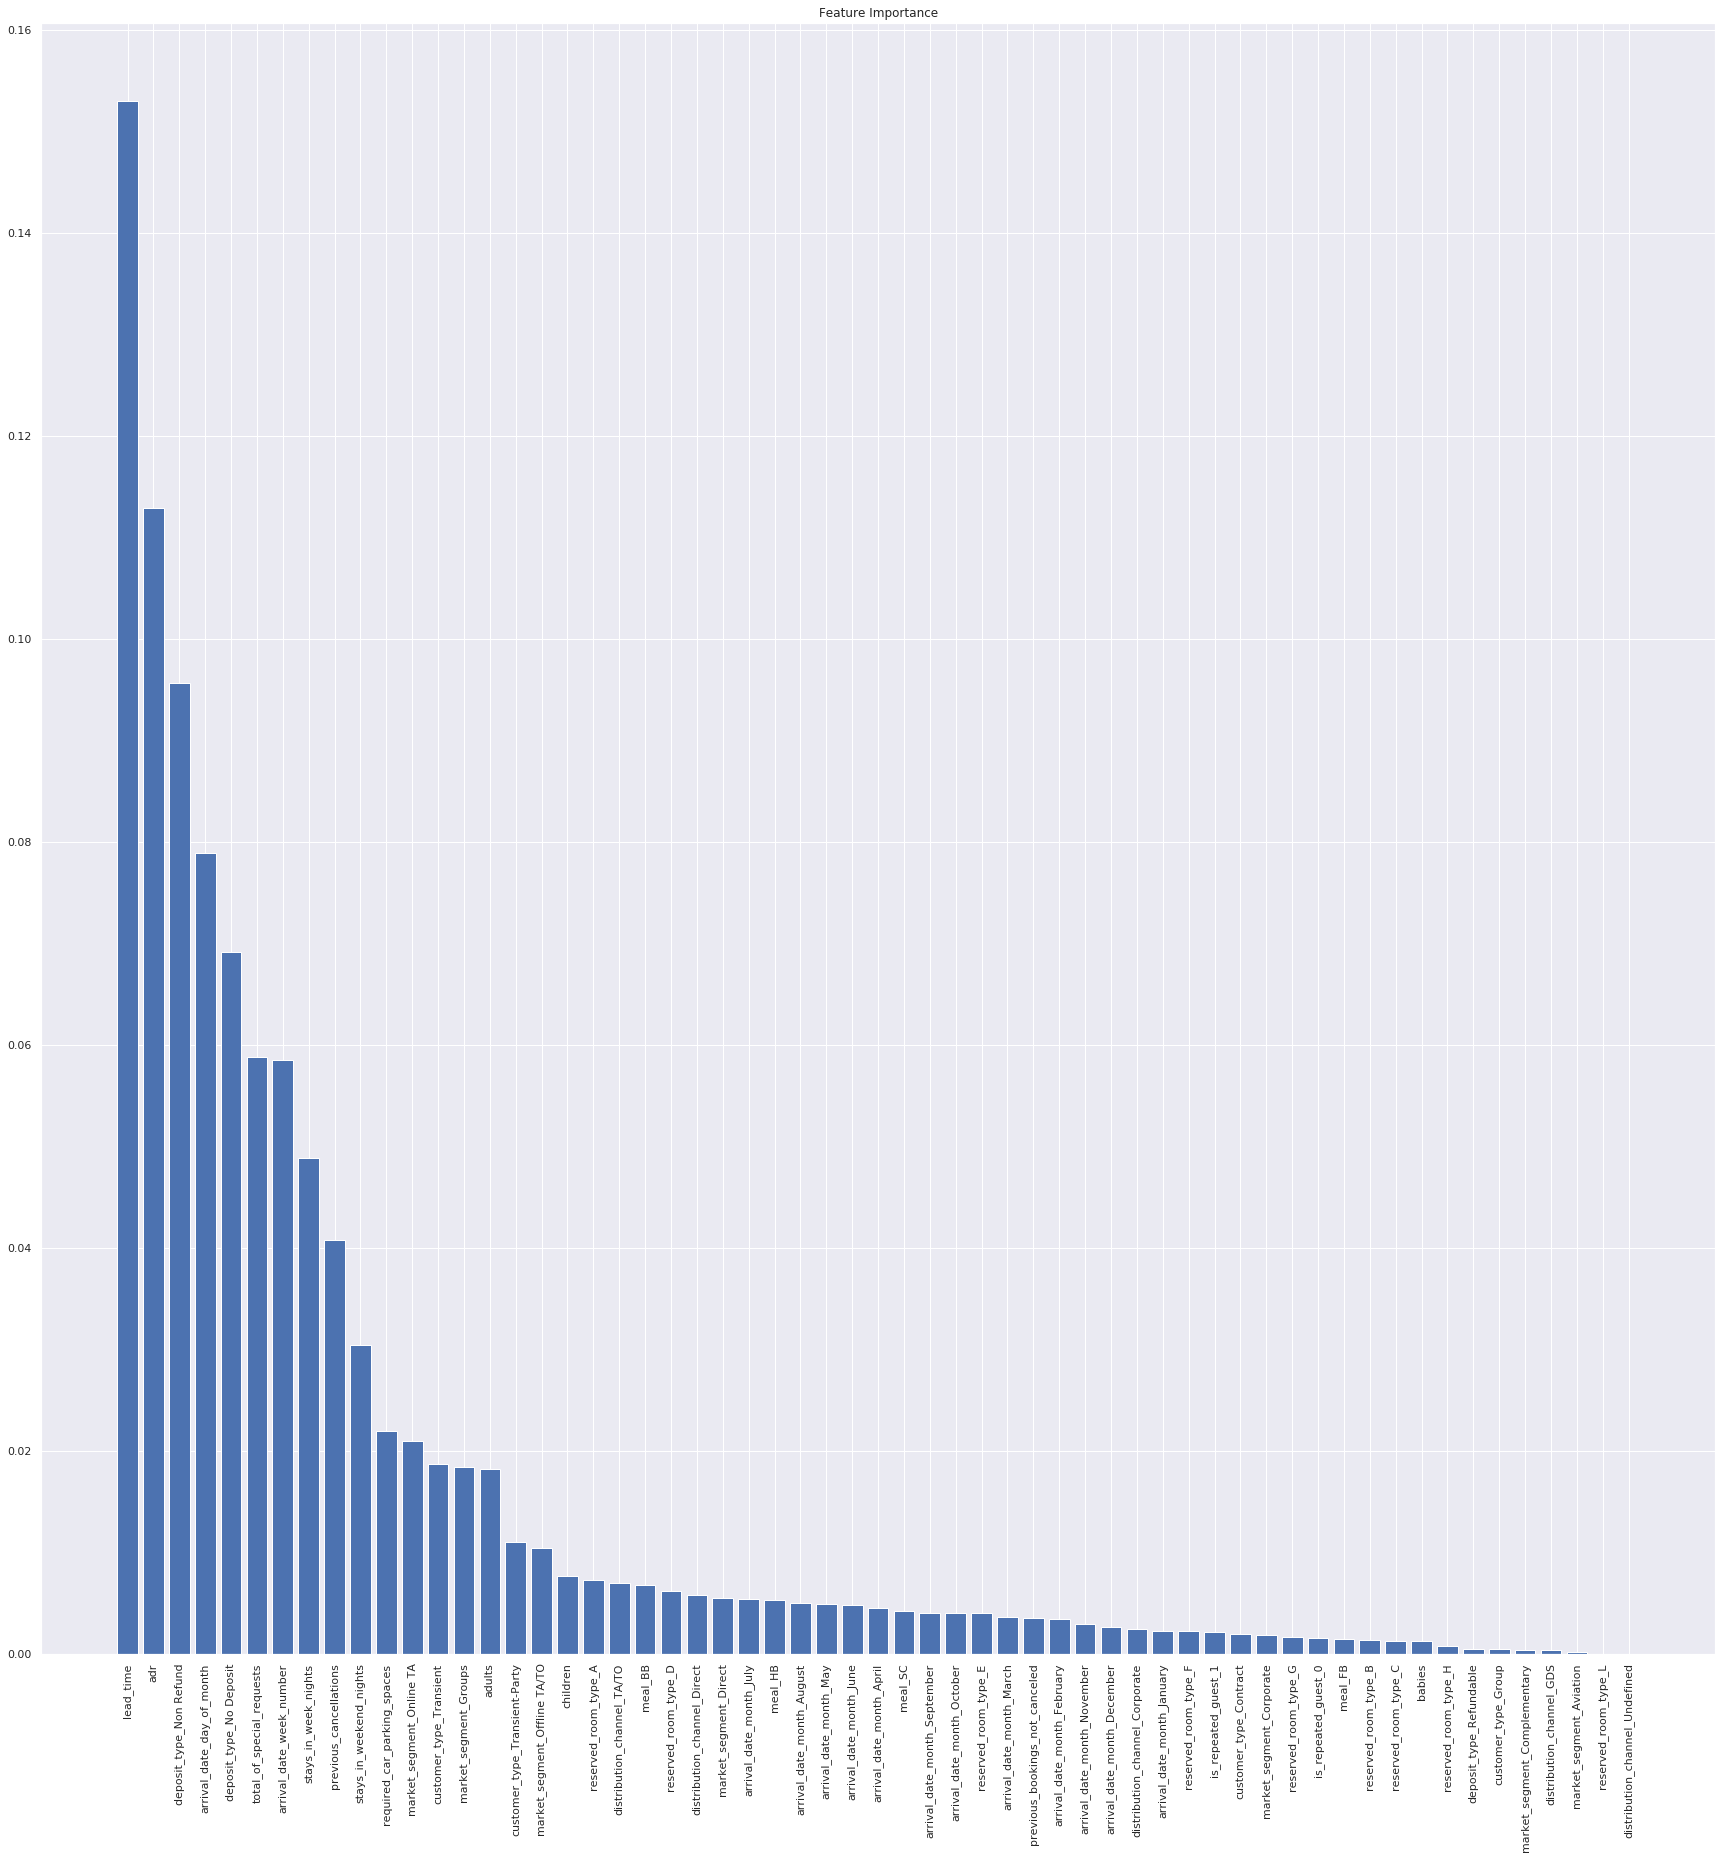

In [61]:
importances = rfl.feature_importances_ 
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X.columns[i] for i in indices]

# Create plot
plt.figure(figsize=(30,30))

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation=90)

# Show plot
plt.show()

In [62]:
indices = np.argsort(importances)[::-1]
feat_labels = X.columns[:]

for f in range(X_train_std.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

 1) lead_time                      0.152991
 2) adr                            0.112892
 3) deposit_type_Non Refund        0.095640
 4) arrival_date_day_of_month      0.078930
 5) deposit_type_No Deposit        0.069108
 6) total_of_special_requests      0.058756
 7) arrival_date_week_number       0.058504
 8) stays_in_week_nights           0.048845
 9) previous_cancellations         0.040806
10) stays_in_weekend_nights        0.030450
11) required_car_parking_spaces    0.021998
12) market_segment_Online TA       0.020966
13) customer_type_Transient        0.018714
14) market_segment_Groups          0.018407
15) adults                         0.018187
16) customer_type_Transient-Party  0.011035
17) market_segment_Offline TA/TO   0.010413
18) children                       0.007723
19) reserved_room_type_A           0.007265
20) distribution_channel_TA/TO     0.006938
21) meal_BB                        0.006821
22) reserved_room_type_D           0.006212
23) distribution_channel_Direct 

In [0]:
from sklearn.metrics import roc_curve, roc_auc_score

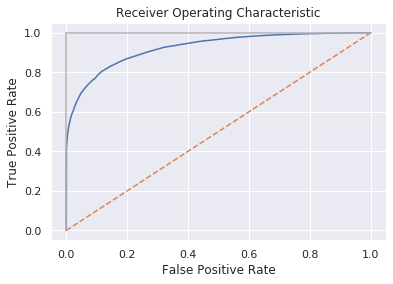

In [64]:
y_score = rfl.predict_proba(X_test_std)[:,1]
# Create true and false positive rates
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)
# Plot ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [65]:
!pip install scikit-plot
import scikitplot as skplt

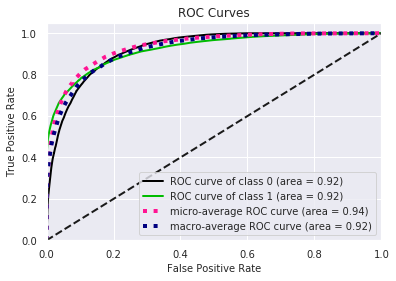

In [66]:
rf = rfl.fit(X_train_std, y_train)
y_probas = rf.predict_proba(X_test_std)
skplt.metrics.plot_roc(y_test,y_probas)
plt.show()

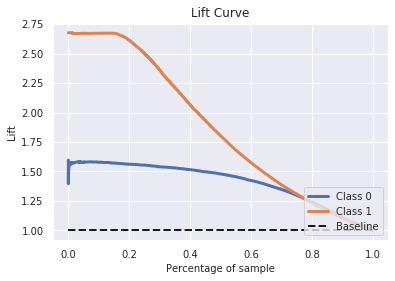

In [67]:
skplt.metrics.plot_lift_curve(y_test, y_probas)
plt.show()

So, the best model is the Random Forest with precision of 0.86, recall of 0.74, and overall accuracy of 0.8570. Also, we are able to interpret the model results by extracting feature importances.